# Multi-armed bandit Algorithm with Slot Machine Data

### 요약
이 노트북의 목적은 데이터 시각화를 통해[Data_Exploration.ipynb] 제작한 [Slot Machine](https://github.com/Jaepal/data-science-portfolio/blob/master/slot_machine/slot.py)에 Multi-armed bandit 알고리즘을 적용하여 어떤 Slot Machine이 가장 높은 RTP를 가지고 있는지 도출하고, 어떤 decision policy가 가장 좋은 성능을 가지고 있는지 테스트합니다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta as beta_dist
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from tqdm import tqdm
import slot
import imsi

plt.rcParams['animation.ffmpeg_path'] = 'C:/FFmpeg/bin/ffmpeg.exe'

In [2]:
class MAB:
    def __init__(self, bpl, slots, bandit_probs):
        
        # bandit의 확률 저장
        self.bandit_probs = bandit_probs
        # bet per line 저장
        self.bpl = bpl
        # slot의 수 저장
        self.N = len(slots)
        # platinum slot 저장
        self.slot_platinum = imsi.game_platinum(bpl)
        # monster slot 저장
        self.slot_monster = imsi.game_monster(bpl)
        # masquerade slot 저장
        self.slot_masque = imsi.game_masque(bpl)

    def draw(self, k):
        if k == 0:
            return self.slot_platinum.play(), np.max(self.bandit_probs) - self.bandit_probs[k]
        elif k == 1:
            return self.slot_monster.play(), np.max(self.bandit_probs) - self.bandit_probs[k]
        elif k == 2:
            return self.slot_masque.play(), np.max(self.bandit_probs) - self.bandit_probs[k]


In [3]:
# bandit의 rtp 저장
rtp_values = np.array([0.583, 0.416, 0.382])

# bet per line 값
bpl = 2000

# slot의 종류
slots = ['Platinum', 'Monster 101', 'Masquerade']

In [4]:
# MAB class
mab = MAB(bpl, slots, rtp_values)

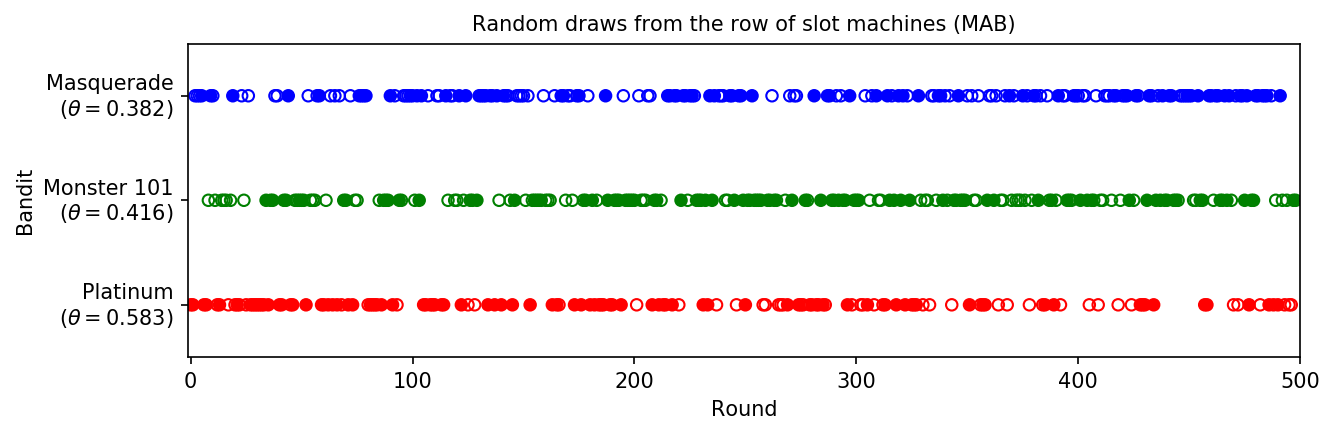

In [5]:
# draw 수
N_DRAWS = 500

# bandit의 수
N_BANDITS = len(slots)

# 누적 draw, bandit의 선택과 보상을 위한
k_array = np.zeros((N_BANDITS,N_DRAWS))
reward_array = np.zeros((N_BANDITS,N_DRAWS))

# visualization을 위한 list
k_list = []
reward_list = []

# fig 설정
fig, ax = plt.subplots(figsize=(9, 3), dpi=150)
ax.set(xlim=(-1, N_DRAWS), ylim=(-0.5, N_BANDITS-0.5))

# 각 bandit의 색상
bandit_colors = ['red', 'green', 'blue']

# draw 반복
for draw_number in range(N_DRAWS):
    
    # arm을 선택하고 draw 함
    k = np.random.choice(range(N_BANDITS),1)[0]
    reward, regret = mab.draw(k)
    
    if reward > 0:
        reward = 1
    else:
        reward = 0
    
    # 이 draw 정보 기록
    k_list.append(k)
    reward_list.append(reward)
    k_array[k, draw_number] = 1
    reward_array[k, draw_number] = reward
    
    # bandit의 color list
    color_list = [bandit_colors[k] for k in k_list]
    
    # reward의 facecolor
    facecolor_list = [['none', bandit_colors[k_list[i]]][r] for i, r in enumerate(reward_list)]    

# 데이터 initializing
scatter = ax.scatter(y=[k_list[0]], x=[list(range(N_DRAWS))[0]], color=[color_list[0]], linestyle='-', marker='o', s=30, facecolor=[facecolor_list[0]]);

# 시각화 타이틀
plt.title('Random draws from the row of slot machines (MAB)', fontsize=10)
plt.xlabel('Round', fontsize=10); plt.ylabel('Bandit', fontsize=10);
ax.set_yticks([0,1,2])
ax.set_yticklabels(['{}\n($\\theta = {}$)'.format(slots[i], rtp_values[i]) for i in range(3)])
ax.tick_params(labelsize=10)
fig.tight_layout()

# update를 위한 함수
def animate(i):
    x = list(range(N_DRAWS))[:i]
    y = k_list[:i]
    scatter.set_offsets(np.c_[x, y])
    scatter.set_color(color_list[:i])
    scatter.set_facecolor(facecolor_list[:i])
    ax.set_yticks([0,1,2])
    ax.set_yticklabels(['{}\n($\\theta = {}$)'.format(slots[i], rtp_values[i]) for i in range(3)])
    ax.tick_params(labelsize=10)
    return (scatter,)


# animation 생성 함수
anim = FuncAnimation(fig, animate, frames=N_DRAWS, interval=25, blit=True)

# 출력
HTML(anim.to_html5_video())

In [6]:
def get_beta_pdf(alpha, beta):
    X = np.linspace(0,1,1000)
    return X, beta_dist(1 + alpha,1 + beta).pdf(X)

In [7]:
def plot_MAB_experiment(decision_policy, N_DRAWS, bandit_probs, plot_title):

    # 지난 figure 삭제
    plt.close('all')

    # bandit의 수
    N_BANDITS = len(bandit_probs)
    
    # 누적 draw, bandit 선택과 reward를 위한 numpy array
    k_array = np.zeros((N_BANDITS,N_DRAWS))
    reward_array = np.zeros((N_BANDITS,N_DRAWS))
    
    # 누적 draw, bandit 선택과 reward를 위한 list
    k_list = []
    reward_list = []
    reward_switch = []

    # animation dict
    posterior_anim_dict = {i:[] for i in range(N_BANDITS)}

    # figure 생성
    fig = plt.figure(figsize=(9,5), dpi=150)

    # plot의 grid 포지셔닝
    ax1 = plt.subplot2grid((5, 3), (0, 0), colspan=3, rowspan=3)
    ax2 = plt.subplot2grid((5, 3), (3, 0), rowspan=2)
    ax3 = plt.subplot2grid((5, 3), (3, 1), rowspan=2)
    ax4 = plt.subplot2grid((5, 3), (3, 2), rowspan=2)

    # draw 반복
    for draw_number in range(N_DRAWS):

        # 해당 draw의 정보 저장
        k = decision_policy.choose_bandit(k_array, reward_array, N_BANDITS)
        reward, regret = mab.draw(k)

        # 해당 draw의 정보 저장
        k_list.append(k)
        reward_list.append(reward)
        k_array[k, draw_number] = 1
        reward_array[k, draw_number] = reward
        
        if reward:
            reward_switch.append(1)
        else:
            reward_switch.append(0)
        
        """
        # sucesses and failures for our beta distribution
        success_count = reward_array.sum(axis=1)
        failure_count = k_array.sum(axis=1) - success_count
        """
        
        # 각 bandit의 pdf 계산
        for bandit_id in range(N_BANDITS):

            # pdf
            X, curve = get_beta_pdf(decision_policy.alpha[bandit_id], decision_policy.beta[bandit_id])

            # pdf animation dict에 추가
            posterior_anim_dict[bandit_id].append({'X': X, 'curve': curve})

        # bandit을 색으로 구분하기 위해 list 생성
        color_list = [bandit_colors[k] for k in k_list]

        # 보상을 면색으로 구분하기 위해 list 생성
        facecolor_list = [['none', bandit_colors[k_list[i]]][r] for i, r in enumerate(reward_switch)]
        
        decision_policy.update(k, reward)
    
    # plot의 properties
    ax1.set(xlim=(-1, N_DRAWS), ylim=(-0.5, N_BANDITS-0.5))
    ax1.set_title(plot_title, fontsize=10)
    ax1.set_xlabel('Round', fontsize=10); ax1.set_ylabel('Bandit', fontsize=10)
    ax1.set_yticks([0,1,2,3])
    ax1.set_yticklabels(['{}\n($\\theta = {}$)'.format(slots[i], bandit_probs[i]) for i in range(3)])
    ax1.tick_params(labelsize=10)

    # distribution plots의 title
    ax2.set_title('Estimated $\\theta_0$', fontsize=10); ax3.set_title('Estimated $\\theta_1$', fontsize=10); 
    ax4.set_title('Estimated $\\theta_2$', fontsize=10)

    # 초기의 데이터로 initializing
    scatter = ax1.scatter(y=[k_list[0]], x=[list(range(N_DRAWS))[0]], color=[color_list[0]], linestyle='-', marker='o', s=30, facecolor=[facecolor_list[0]]);
    dens1 = ax2.fill_between(posterior_anim_dict[0][0]['X'], 0, posterior_anim_dict[0][0]['curve'], color='red', alpha=0.7)
    dens2 = ax3.fill_between(posterior_anim_dict[1][0]['X'], 0, posterior_anim_dict[1][0]['curve'], color='green', alpha=0.7)
    dens3 = ax4.fill_between(posterior_anim_dict[2][0]['X'], 0, posterior_anim_dict[2][0]['curve'], color='blue', alpha=0.7)
    #dens4 = ax5.fill_between(posterior_anim_dict[3][0]['X'], 0, posterior_anim_dict[3][0]['curve'], color='purple', alpha=0.7)

    # titles
    #plt.title('Random draws from the row of slot machines (MAB)', fontsize=10)
    #plt.xlabel('Round', fontsize=10); plt.ylabel('Bandit', fontsize=10);

    # update를 위한 function
    def animate(i):

        # clearing axes
        ax1.clear(); ax2.clear(); ax3.clear(); ax4.clear();

        # game rounds 업데이트
        scatter = ax1.scatter(y=k_list[:i], x=list(range(N_DRAWS))[:i], color=color_list[:i], 
                              linestyle='-', marker='o', s=30, facecolor=facecolor_list[:i]);

        # plot의 properties
        ax1.set(xlim=(-1, N_DRAWS), ylim=(-0.5, N_BANDITS-0.5))
        ax1.set_title(plot_title, fontsize=10)
        ax1.set_xlabel('Round', fontsize=10); ax1.set_ylabel('Bandit', fontsize=10)
        ax1.set_yticks([0,1,2])
        ax1.set_yticklabels(['{}\n($\\theta = {}$)'.format(slots[i], bandit_probs[i]) for i in range(3)])
        ax1.tick_params(labelsize=10)

        # 분포 업데이터
        dens1 = ax2.fill_between(posterior_anim_dict[0][i]['X'], 0, posterior_anim_dict[0][i]['curve'], color='red', alpha=0.7)
        dens2 = ax3.fill_between(posterior_anim_dict[1][i]['X'], 0, posterior_anim_dict[1][i]['curve'], color='green', alpha=0.7)
        dens3 = ax4.fill_between(posterior_anim_dict[2][i]['X'], 0, posterior_anim_dict[2][i]['curve'], color='blue', alpha=0.7)
        #dens4 = ax5.fill_between(posterior_anim_dict[3][i]['X'], 0, posterior_anim_dict[3][i]['curve'], color='purple', alpha=0.7)

        # distribution plots의 title
        ax2.set_title('Estimated $\\theta_0$', fontsize=10); ax3.set_title('Estimated $\\theta_1$', fontsize=10); 
        ax4.set_title('Estimated $\\theta_2$', fontsize=10);
        
        return ()

    # animation 제작을 위한 function
    anim = FuncAnimation(fig, animate, frames=N_DRAWS, interval=100, blit=True)

    # layout 고정
    fig.tight_layout()

    # 출력
    return HTML(anim.to_html5_video())

In [8]:
# e-greedy policy
class eGreedyPolicy:
    
    def __init__(self, epsilon, bandit):
        
        # epsilon 저장
        self.epsilon = epsilon
        self.alpha = np.ones(bandit.N, dtype=np.float)
        self.beta = np.ones(bandit.N, dtype=np.float)
    
    # bandit 선택
    def choose_bandit(self, k_array, reward_array, n_bandits):
        
        # 총 reward와 count
        total_reward = reward_array.sum(axis=1)
        total_count = k_array.sum(axis=1)
        
        # sucesses vs total 비율
        rtp_value = total_reward / total_count
        
        # epsilon 확률에 따라 greedy action 또는 random action
        if np.random.random() < self.epsilon:
            
            # 최고의 선택을 제외한 random action 리턴
            return np.random.choice(np.delete(list(range(N_BANDITS)), np.argmax(rtp_value)))
        
        # 또는 최고의 선택을 리턴
        else:
            
            # greedy action 리턴
            return np.argmax(rtp_value)
        
    def update(self, k, reward):
        while(reward >= 60000):
            self.alpha[k] += 1
            reward -= 60000
        self.beta[k] += 1 - reward / 60000
        self.alpha[k] += reward / 60000

In [9]:
e_greedy_policy = eGreedyPolicy(0.10, mab)

C:\Users\Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


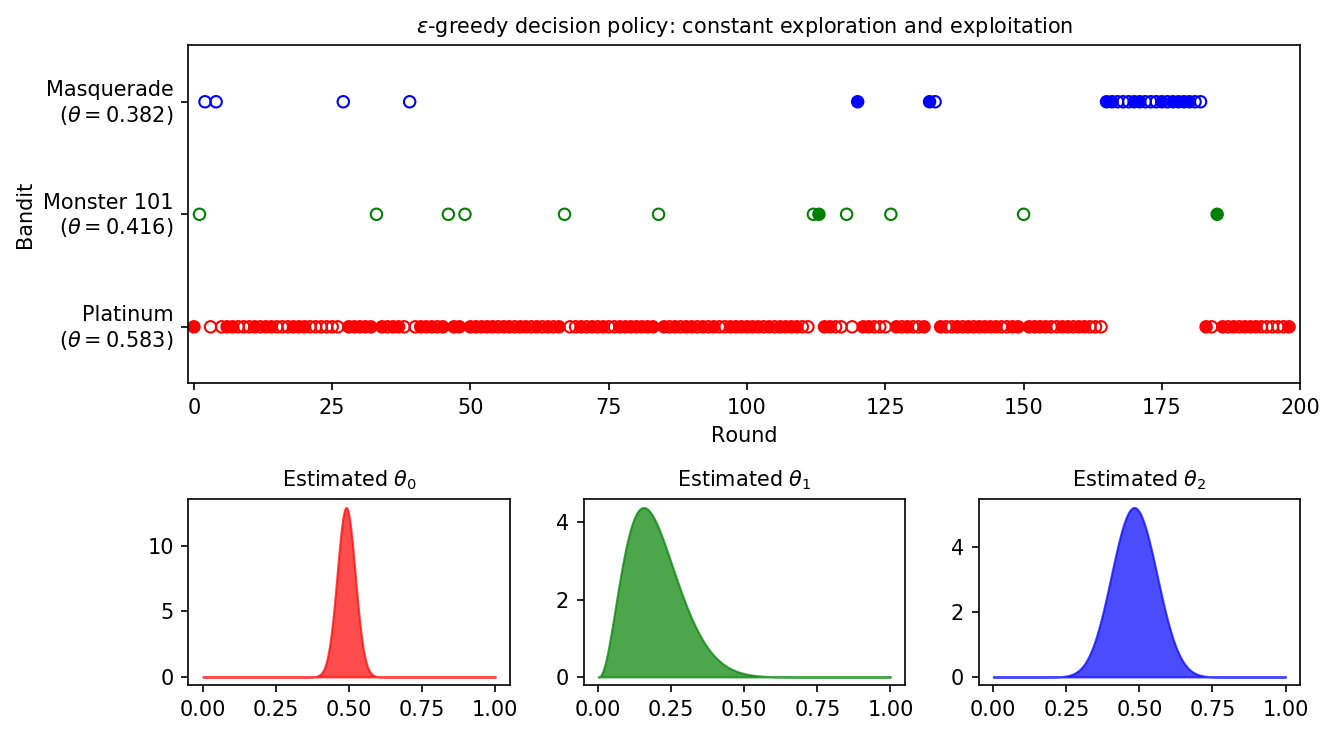

In [10]:
plot_MAB_experiment(e_greedy_policy, 200, mab.bandit_probs, '$\epsilon$-greedy decision policy: constant exploration and exploitation')

In [11]:
# ucb policy
class UCBPolicy:
    
    def __init__(self, bandit):
        
        self.alpha = np.ones(bandit.N, dtype=np.float)
        self.beta = np.ones(bandit.N, dtype=np.float)
    
    # bandit 선택
    def choose_bandit(self, k_array, reward_array, n_bandits):
        
        # 총 reward와 count
        total_reward = reward_array.sum(axis=1)
        total_count = k_array.sum(axis=1)
        
        # sucesses vs total 비율
        rtp_value = total_reward / (total_count * 60000)
        
        # square root term 계산
        sqrt_term = np.sqrt(2*np.log(np.sum(total_count))/total_count)
        
        # best greedy action 리턴
        return np.argmax(rtp_value + sqrt_term)
    
    def update(self, k, reward):
        while(reward >= 60000):
            self.alpha[k] += 1
            reward -= 60000
        self.beta[k] += 1 - reward / 60000
        self.alpha[k] += reward / 60000

In [12]:
ucb_policy = UCBPolicy(mab)

C:\Users\Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log
C:\Users\Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in sqrt
C:\Users\Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


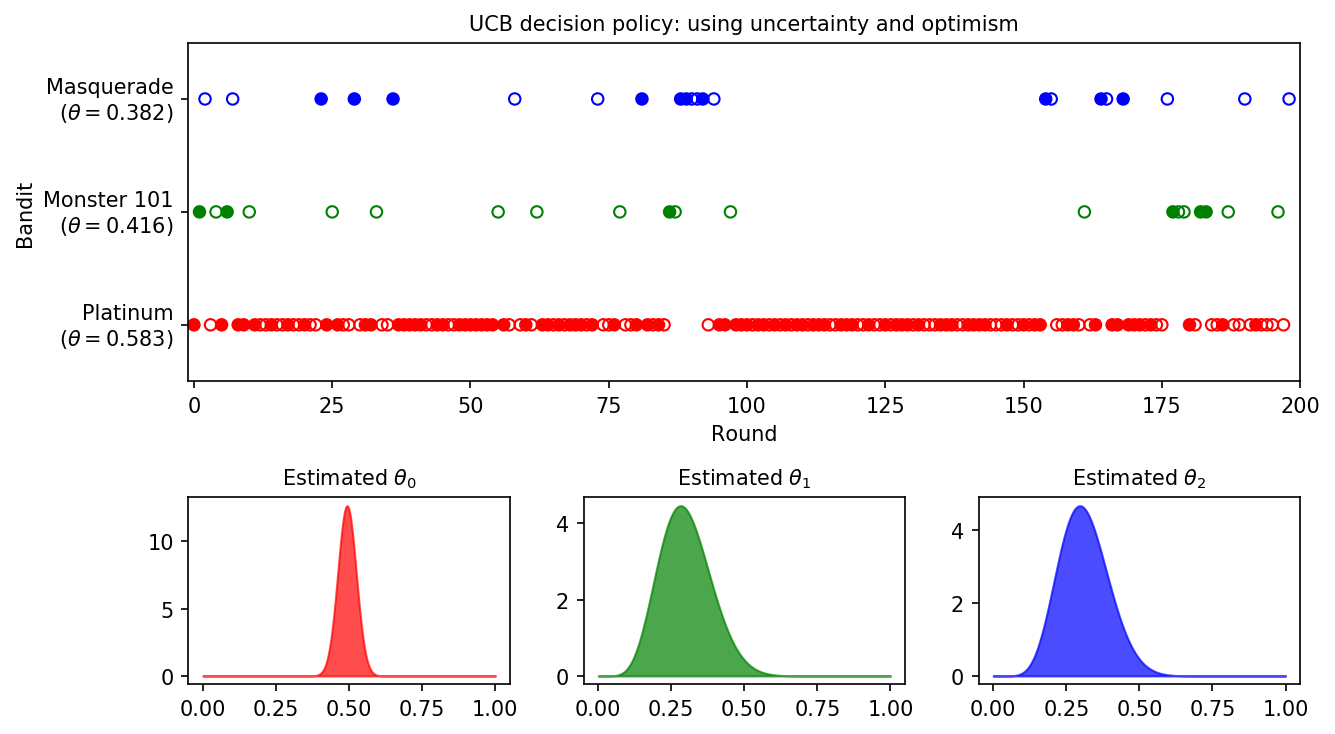

In [13]:
plot_MAB_experiment(ucb_policy, 200, mab.bandit_probs, 'UCB decision policy: using uncertainty and optimism')

In [14]:
class TSPolicy:
    
    def __init__(self, bandit):
        
        self.alpha = np.ones(bandit.N, dtype=np.float)
        self.beta = np.ones(bandit.N, dtype=np.float)
    
    # bandit 선택
    def choose_bandit(self, k_array, reward_array, n_bandits):

        # 각 bandit의 sample
        samples_list = []
        
        # 총 reward와 count
        total_reward = reward_array.sum(axis=1)
        total_count = k_array.sum(axis=1)
        
        # sucesses vs total 비율
        rtp_value = total_reward / total_count
                    
        # 각 bandit의 distribution에서 sample을 draw
        samples_list = [np.random.beta(self.alpha[bandit_id], self.beta[bandit_id]) for bandit_id in range(n_bandits)]
                                
        # 최고의 sample을 가진 bandit 리턴
        return np.argmax(samples_list)
    
    def update(self, k, reward):
        while(reward >= 60000):
            self.alpha[k] += 1
            reward -= 60000
        self.beta[k] += 1 - reward / 60000
        self.alpha[k] += reward / 60000

In [15]:
ts_policy = TSPolicy(mab)

C:\Users\Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


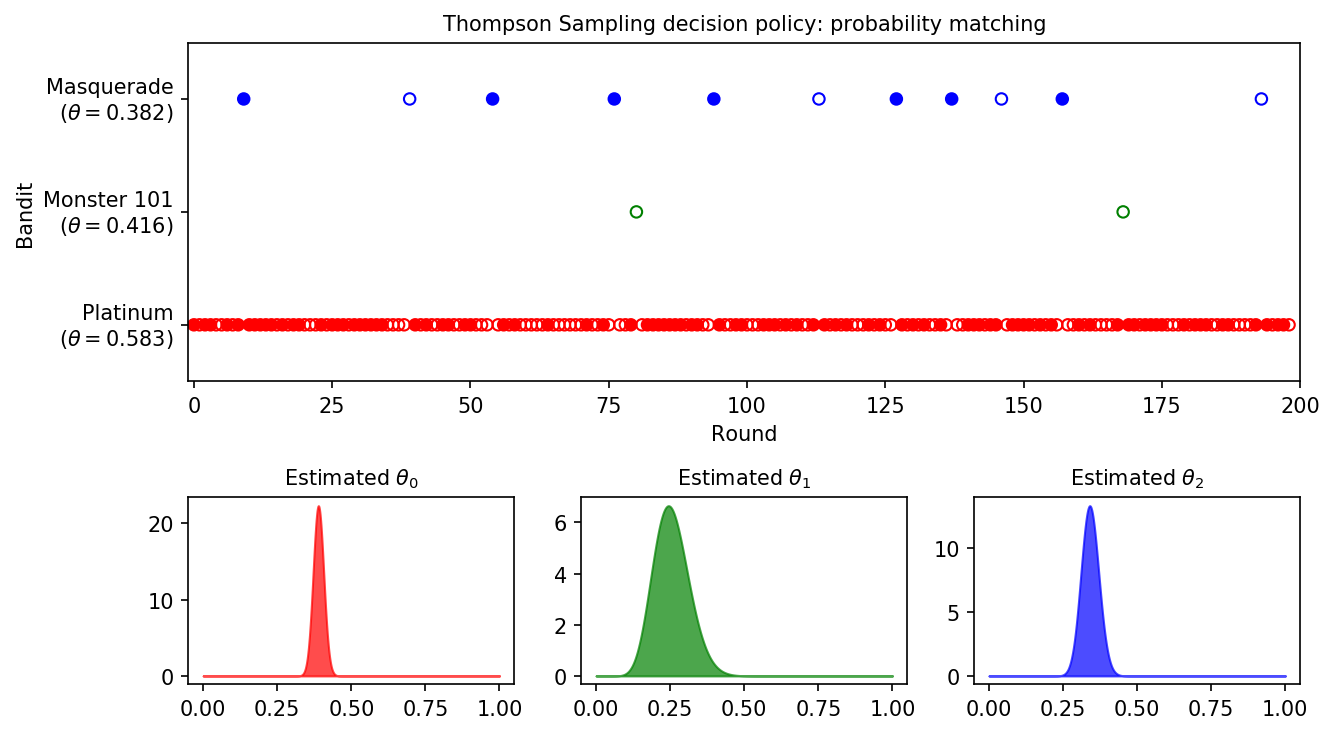

In [19]:
plot_MAB_experiment(ts_policy, 200, mab.bandit_probs, 'Thompson Sampling decision policy: probability matching')

In [20]:
#### SIMULATION ####

# round 횟수
N_ROUNDS = 10000
# simulation 횟수
N_SIMULATIONS = 100

# 각각의 decision policy를 저장할 dict
dp_dict = {'e_greedy': e_greedy_policy,
           'ucb': ucb_policy,
           'ts': ts_policy}

# 각 algorithm과 simulation의 결과를 저장할 dict
result_dict = {'e_greedy': {'k_array': np.zeros((N_BANDITS,N_ROUNDS)),
                            'reward_array': np.zeros((N_BANDITS,N_ROUNDS)),
                            'regret_array': np.zeros((1,N_ROUNDS))[0]},
               'ucb': {'k_array': np.zeros((N_BANDITS,N_ROUNDS)),
                       'reward_array': np.zeros((N_BANDITS,N_ROUNDS)),
                       'regret_array': np.zeros((1,N_ROUNDS))[0]},
               'ts': {'k_array': np.zeros((N_BANDITS,N_ROUNDS)),
                      'reward_array': np.zeros((N_BANDITS,N_ROUNDS)),
                      'regret_array': np.zeros((1,N_ROUNDS))[0]}
               }

# 각 알고리즘별 반복
for key, decision_policy in dp_dict.items():
    
    # progress를 print
    print(key, decision_policy)
    
    # 각 시뮬레이션 반복
    for simulation in tqdm(range(N_SIMULATIONS)):
        
        # 누적 draw 횟수, bandit 선택과 보상, regret을 저장할 numpy array 생성
        k_array = np.zeros((N_BANDITS,N_ROUNDS))
        reward_array = np.zeros((N_BANDITS,N_ROUNDS))
        regret_array = np.zeros((1,N_ROUNDS))[0]
        
        # 각 라운드 반복
        for round_id in range(N_ROUNDS):
            
            # arm을 선택하고 draw
            k = decision_policy.choose_bandit(k_array, reward_array, N_BANDITS)
            reward, regret = mab.draw(k)
            
            # 이 draw에 대한 정보를 기록
            k_array[k, round_id] = 1
            reward_array[k, round_id] = reward
            regret_array[round_id] = regret
            
            decision_policy.update(k, reward)
        
        # 이 simulation에 대한 결과
        result_dict[key]['k_array'] += k_array
        result_dict[key]['reward_array'] += reward_array
        result_dict[key]['regret_array'] += regret_array

e_greedy <__main__.eGreedyPolicy object at 0x0000021310CA45F8>


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [20:56<00:00, 12.34s/it]


ucb <__main__.UCBPolicy object at 0x000002131623BC18>


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log
C:\Users\Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in sqrt
C:\Users\Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [16:31<00:00,  9.23s/it]


ts <__main__.TSPolicy object at 0x00000213128A99B0>


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [15:17<00:00,  9.14s/it]


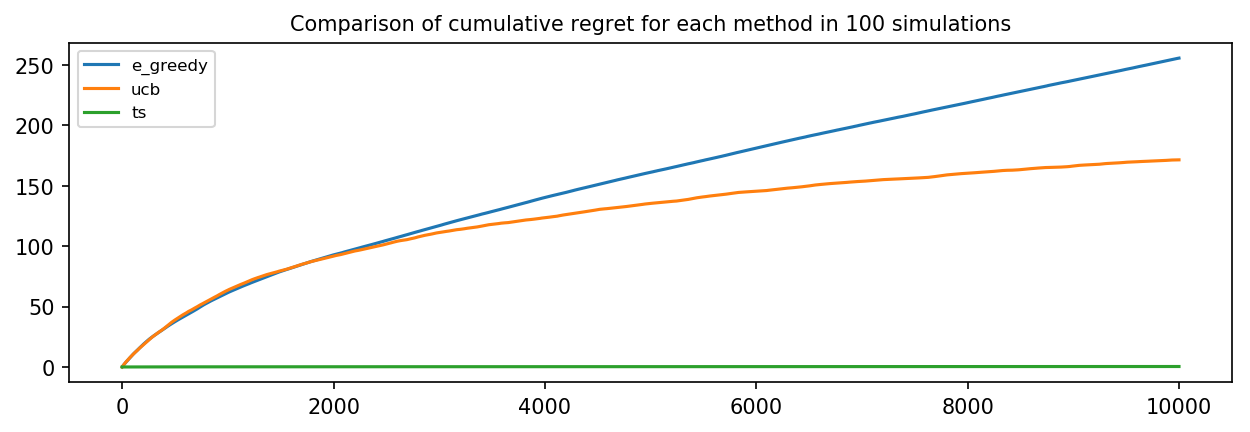

In [21]:
# 지난 figure 삭제
plt.close('all')

# regret function을 plot하기 위한 figure
plt.figure(figsize=(10, 3), dpi=150)

# 각 decision policy 반복
for policy in ['e_greedy','ucb','ts']:
    
    # 데이터 plotting
    plt.plot(np.cumsum(result_dict[policy]['regret_array']/N_SIMULATIONS), label=policy, linewidth=1.5);
    
# title 추가
plt.title('Comparison of cumulative regret for each method in {} simulations'.format(N_SIMULATIONS), fontsize=10)

# legend 추가
plt.legend(fontsize=8); plt.xticks(fontsize=10); plt.yticks(fontsize=10)

# 출력
plt.show()

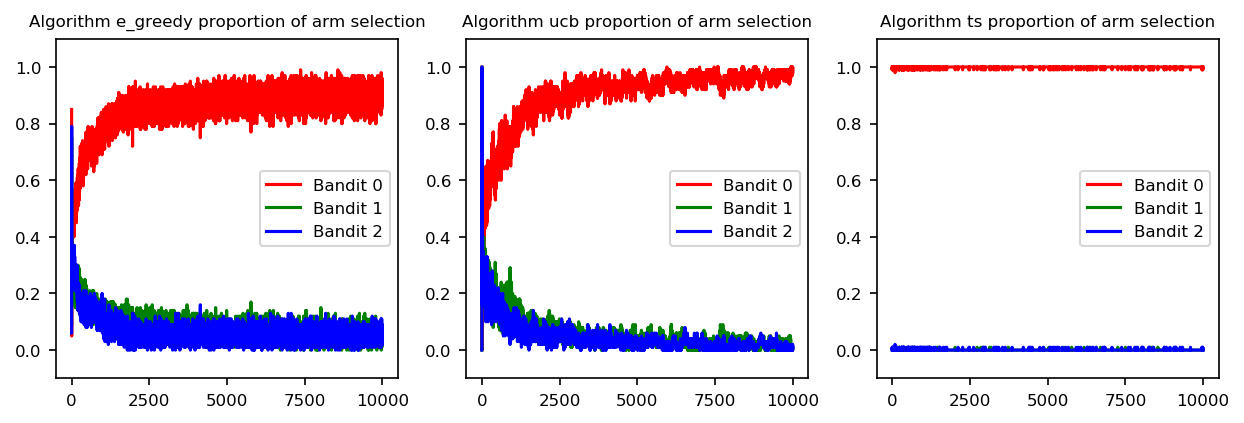

In [22]:
# 지난 figure 삭제
plt.close('all')

# regret function을 plot 하기 위한 figure
plt.figure(figsize=(10, 3), dpi=150)

# 각 bandit의 색
bandit_colors = ['red', 'green', 'blue']

# 각 decision policy 별로 반복
for i, policy in enumerate(['e_greedy','ucb','ts']):
    
    # subplots
    plt.subplot(1,3,i+1)
    
    # 각 arm 별로 반복
    for arm in range(N_BANDITS):
    
        # 데이터 plot
        plt.plot(result_dict[policy]['k_array'][arm]/N_SIMULATIONS, label='Bandit {}'.format(arm), linewidth=1.5, color=bandit_colors[arm]);
    
        # title 추가
        plt.title('Algorithm {} proportion of arm selection'.format(policy), fontsize=8)

        # legend 추가
        plt.legend(fontsize=8); plt.xticks(fontsize=8); plt.yticks(fontsize=8); plt.ylim([-0.1,1.1])

# 출력
plt.show()